# Sentiment Analysis

In [45]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Data Preprocessing

In [62]:
df = pd.read_csv("data.csv")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [47]:
df.drop(columns=['textID', 'selected_text', 'Time of Tweet','Age of User', 'Country', 'Population -2020', 'Land Area (Km²)', 'Density (P/Km²)' ], inplace=True)

In [48]:
df

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


In [49]:
sentiment_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
df['Encoded'] = df['sentiment'].map(sentiment_mapping)

In [50]:
df.head()

,text,sentiment,Encoded
0,"I`d have responded, if I were going",neutral,2
1,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,my boss is bullying me...,negative,0
3,what interview! leave me alone,negative,0
4,"Sons of ****, why couldn`t they put them on t...",negative,0


In [51]:
df.dropna(inplace=True)

In [52]:
X = df['text'].astype('str')
X = list(X)
Y = df['Encoded']

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state=42, stratify=Y)

print('NO. OF TRAINING EXAMPLES:', len(X_train), ' TYPE: ', type(X_train))
print('NO. OF VALIDATION EXAMPLES:', len(X_test), ' TYPE: ', type(X_test))

NO. OF TRAINING EXAMPLES: 23358  TYPE:  <class 'list'>
NO. OF VALIDATION EXAMPLES: 4122  TYPE:  <class 'list'>


In [54]:
def show_example(data):
    print(random.sample(data, 1))
    
show_example(X_train)
show_example(X_test)

[' sad, but true']
['i`ve become one of those pathetic girls that feel lonely without their boyfriends hahaha i miss josey already!!']


## Creating Tokenizer

In [55]:
NUM_WORDS = 1000
OOV_TOKEN = '<<OOV>>'
MAXLEN = 40
PADDING_TYPE = 'post'
TRUNCATING_TYPE = 'post'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=NUM_WORDS,
    oov_token=OOV_TOKEN
)

tokenizer.fit_on_texts(X_train)


tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json_file.write(tokenizer_json)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_train_sequences,
    maxlen=MAXLEN,
    padding=PADDING_TYPE,
    truncating=TRUNCATING_TYPE
)

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_test_sequences,
    maxlen=MAXLEN,
    padding=PADDING_TYPE,
    truncating=TRUNCATING_TYPE
)

In [56]:
EMBEDDING_DIM = 8

model = tf.keras.Sequential([
    layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    layers.Flatten(),
    layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 8)             8000      
                                                                 
 flatten_3 (Flatten)         (None, 320)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 963       
                                                                 
Total params: 8,963
Trainable params: 8,963
Non-trainable params: 0
_________________________________________________________________


## Creating Model

In [57]:
SAVED_MODEL_PATH = '/Users/keith/Desktop/Hackathon/new.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    SAVED_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=True
)

In [58]:
history = model.fit(
    X_train_padded,
    Y_train,
    epochs=50,
    validation_data=(X_test_padded, Y_test),
    callbacks=[model_checkpoint]
)

Epoch 1/50
672/730 [==========================>...] - ETA: 0s - loss: 1.0220 - accuracy: 0.4692
Epoch 1: val_loss improved from inf to 0.88432, saving model to /Users/keith/Desktop/Hackathon/new.h5
730/730 [==============================] - 1s 691us/step - loss: 1.0116 - accuracy: 0.4785 - val_loss: 0.8843 - val_accuracy: 0.5936
Epoch 2/50
705/730 [===========================>..] - ETA: 0s - loss: 0.8054 - accuracy: 0.6502
Epoch 2: val_loss improved from 0.88432 to 0.78402, saving model to /Users/keith/Desktop/Hackathon/new.h5
730/730 [==============================] - 0s 582us/step - loss: 0.8047 - accuracy: 0.6505 - val_loss: 0.7840 - val_accuracy: 0.6657
Epoch 3/50
719/730 [============================>.] - ETA: 0s - loss: 0.7319 - accuracy: 0.6955
Epoch 3: val_loss improved from 0.78402 to 0.76349, saving model to /Users/keith/Desktop/Hackathon/new.h5
730/730 [==============================] - 0s 571us/step - loss: 0.7321 - accuracy: 0.6956 - val_loss: 0.7635 - val_accuracy: 0.6691

Epoch 30/50
692/730 [===========================>..] - ETA: 0s - loss: 0.5085 - accuracy: 0.8033
Epoch 30: val_loss did not improve from 0.75889
730/730 [==============================] - 0s 581us/step - loss: 0.5111 - accuracy: 0.8023 - val_loss: 1.0089 - val_accuracy: 0.6305
Epoch 31/50
698/730 [===========================>..] - ETA: 0s - loss: 0.5097 - accuracy: 0.8011
Epoch 31: val_loss did not improve from 0.75889
730/730 [==============================] - 0s 577us/step - loss: 0.5088 - accuracy: 0.8012 - val_loss: 1.0177 - val_accuracy: 0.6300
Epoch 32/50
706/730 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.8049
Epoch 32: val_loss did not improve from 0.75889
730/730 [==============================] - 0s 572us/step - loss: 0.5064 - accuracy: 0.8047 - val_loss: 1.0311 - val_accuracy: 0.6281
Epoch 33/50
705/730 [===========================>..] - ETA: 0s - loss: 0.5020 - accuracy: 0.8044
Epoch 33: val_loss did not improve from 0.75889
730/730 [============

In [59]:
SAVED_MODEL_PATH = '/Users/keith/Desktop/Hackathon/new.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    SAVED_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    verbose=True
)

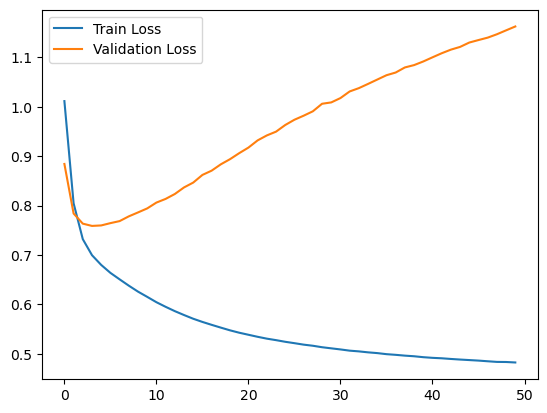

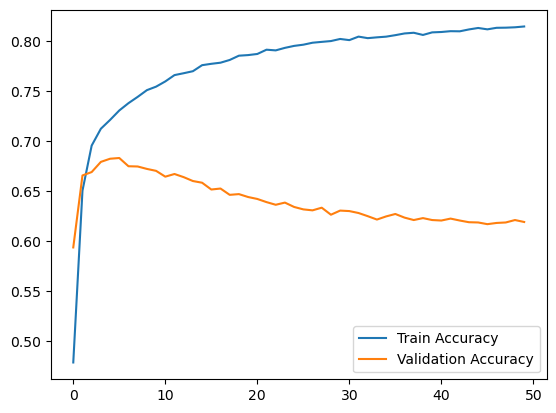

In [60]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [61]:
# Model evaluation
saved_model = tf.keras.models.load_model(SAVED_MODEL_PATH)
evaluation = saved_model.evaluate(X_test_padded, Y_test)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])


np.save('new_label_encoder.npy', label_encoder.classes_)

129/129 [==============================] - 0s 370us/step - loss: 0.7589 - accuracy: 0.6793
Test Loss: 0.7588943839073181
Test Accuracy: 0.6792818903923035
